In [4]:
import torch
import warnings
import json
import os

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from train import ToxicClassifier
from sklearn.metrics.pairwise import cosine_similarity
from detoxify import Detoxify

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [21]:
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    config = checkpoint["config"]
    model = ToxicClassifier(config, device="cpu")
    model.load_state_dict(checkpoint["state_dict"])

    return model

model1 = Detoxify("original-small")
# checkpoint_path = "/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-War-Combined/lightning_logs/version_5/checkpoints/converted/epoch=0-step=34.ckpt"
# model1 = load_checkpoint(checkpoint_path)
checkpoint_path = "/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-War-Combined/lightning_logs/version_18/checkpoints/converted/epoch=0-step=3875.ckpt"
model2 = load_checkpoint(checkpoint_path)

Loading Detoxify model paramters


In [25]:
# Load the state dictionaries of the models
state_dict1 = model1.model.state_dict()
state_dict1 = {k.replace("_", "."): v for k, v in state_dict1.items()}
state_dict2 = model2.state_dict()
state_dict2 = {k.replace("_", "."): v for k, v in state_dict2.items()}

# Compare the keys of the two state dictionaries
print(f"Keys in state_dict1 that are not in state_dict2: {sorted(set(state_dict1.keys()) - set(state_dict2.keys()))}")
print(f"Keys in state_dict2 that are not in state_dict1: {sorted(set(state_dict2.keys()) - set(state_dict1.keys()))}")

for layer_name, weights1 in state_dict1.items():
    if layer_name in state_dict2.keys():
        weights2 = state_dict2[layer_name]
        
        # Compute the absolute difference between the weights
        weight_diff = torch.abs(weights1 - weights2)
        
        # Compute the mean, standard deviation, and maximum value of the weight difference
        mean_diff = torch.mean(weight_diff.float())
        std_diff = torch.std(weight_diff.float())
        max_diff = torch.max(weight_diff.float())
        
        print(f"Layer: {layer_name}")
        # print(f"  Mean difference: {mean_diff:.6f}")
        # print(f"  Std difference: {std_diff:.6f}")
        # print(f"  Max difference: {max_diff:.6f}")
        
        # Compute the cosine similarity between the weights
        cos_sim = cosine_similarity(weights1.reshape(1,-1), weights2.reshape(1,-1))[0,0]
        print(f"\tCosine similarity: {cos_sim:.6f}")
        
        # Compute the KL-divergence between the weights
        weights1_dist = torch.distributions.Normal(weights1, torch.ones_like(weights1))
        weights2_dist = torch.distributions.Normal(weights2, torch.ones_like(weights2))
        kl_div = torch.distributions.kl_divergence(weights1_dist, weights2_dist).mean()
        print(f"\tKL-divergence: {kl_div:.6f}")


Keys in state_dict1 that are not in state_dict2: ['albert.embeddings.position.ids']
Keys in state_dict2 that are not in state_dict1: []
Layer: albert.embeddings.word.embeddings.weight
	Cosine similarity: 0.950313
	KL-divergence: 0.000032
Layer: albert.embeddings.position.embeddings.weight
	Cosine similarity: 0.998859
	KL-divergence: 0.000001
Layer: albert.embeddings.token.type.embeddings.weight
	Cosine similarity: 0.997938
	KL-divergence: 0.000000
Layer: albert.embeddings.LayerNorm.weight
	Cosine similarity: 1.000000
	KL-divergence: 0.000001
Layer: albert.embeddings.LayerNorm.bias
	Cosine similarity: 0.999998
	KL-divergence: 0.000001
Layer: albert.encoder.embedding.hidden.mapping.in.weight
	Cosine similarity: 0.999291
	KL-divergence: 0.000001
Layer: albert.encoder.embedding.hidden.mapping.in.bias
	Cosine similarity: 0.999987
	KL-divergence: 0.000001
Layer: albert.encoder.albert.layer.groups.0.albert.layers.0.full.layer.layer.norm.weight
	Cosine similarity: 1.000000
	KL-divergence: 0.00

In [16]:
def plot_heatmap(activation, layer_idx):
    # Plot the heatmap
    sns.heatmap(activation[0], cmap='viridis')

    # Add labels and title to the plot
    plt.xlabel('Word position')
    plt.ylabel('Neuron')
    plt.title(f'Activation map for layer {layer_idx} of model 1')
    plt.show()


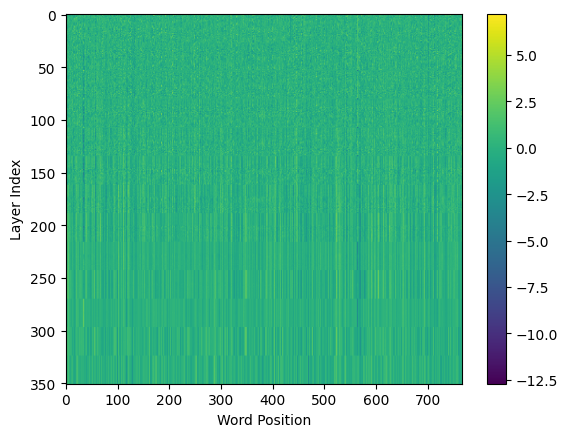

In [22]:
# Define the input sentence for which to generate activation maps
input_sentence = "Fuck you, nazi cunts all of you are Hitler sympathisers I hope you all die in a horrible way"
# Tokenize the input sentence
tokenizer = model1.tokenizer
tokenized_input = tokenizer(input_sentence, return_tensors="pt", truncation=True, padding=True)
# Extract the input tensor from the tokenized input
input_ids = tokenized_input['input_ids']
attention_mask = tokenized_input['attention_mask']

layer_idxs = list(range(0, 13))

# Get the output activations for the first model
with torch.no_grad():
    output1 = model1.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states1 = output1.hidden_states
    logits1 = output1.logits

# Compute the softmax probabilities for each model
probs1 = F.softmax(logits1, dim=1)

# Get the index of the predicted label for each model
pred1 = torch.argmax(probs1, dim=1).item()

# Get the activations for the layers you're interested in
activations1 = torch.cat([hidden_states1[idx] for idx in layer_idxs], dim=1)

# Convert the activations to numpy arrays for visualization
activations1_np = activations1.detach().cpu().numpy()

# Plot the heatmap
plt.imshow(activations1_np[0], cmap='viridis', aspect='auto')
plt.xlabel("Word Position")
plt.ylabel("Layer Index")
plt.colorbar()
plt.show()

# # Get the output activations for the first model
# with torch.no_grad():
#     output1 = model1.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
#     hidden_states1 = output1.hidden_states
#     logits1 = output1.logits

# # Compute the softmax probabilities for each model
# probs1 = F.softmax(logits1, dim=1)

# # Get the index of the predicted label for each model
# pred1 = torch.argmax(probs1, dim=1).item()

# # Get the activations for the layer you're interested in (e.g., layer 6)
# for layer_idx in range(len(hidden_states1)):
#     activations1 = hidden_states1[layer_idx]
#     activations1_np = activations1.detach().cpu().numpy()
#     plot_heatmap(activations1_np, layer_idx)



11678080 weights in this model


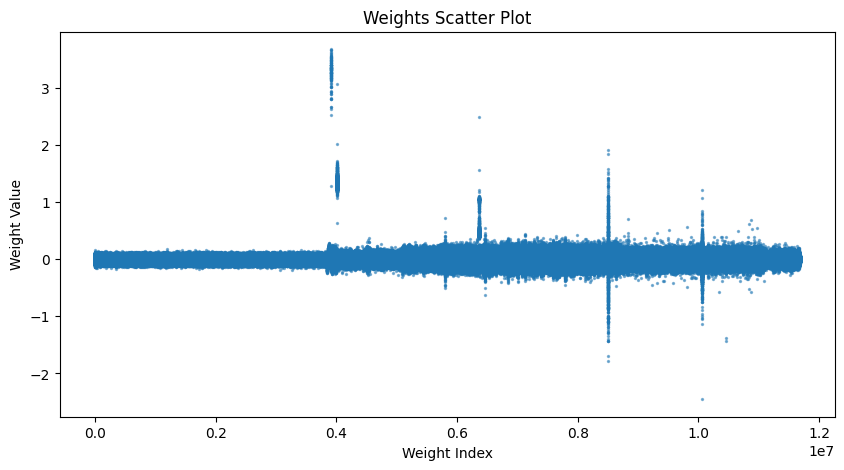

In [27]:
# Get the weights for each layer of the model
weights = []
for name, param in model1.model.named_parameters():
    if 'weight' in name:
        weights.append(param.detach().cpu().numpy().flatten())

# Flatten the weights into a 1D array
weights = np.concatenate(weights)
print(f"{len(weights)} weights in this model")

# Plot the weights as a scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(weights)), weights, s=2, alpha=0.5)
plt.title("Weights Scatter Plot")
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.show()